In [2]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.sparse import vstack, csr_matrix, csc_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [3]:
data_org = pd.read_csv("D:/STAT628m3/final_data1.csv")

In [4]:
data = data_org

In [5]:
data = data.drop(columns = "Year") 
data = data.drop(columns = "Month") 

data = data.drop(columns = "ArrDelay") 
data = data.drop(columns = "DepDelay") 
data = data.drop(columns = "ActualElapsedTime") 

# These two api could not be found
data = data.drop(columns = "Origin_HourlyAltimeterSetting") 
data = data.drop(columns = "Dest_HourlyAltimeterSetting") 

In [6]:
data['DayOfWeek']=data['DayOfWeek'].astype('category')
data['Operating_Airline ']=data['Operating_Airline '].astype('category')
data['Origin']=data['Origin'].astype('category')
data['Dest']=data['Dest'].astype('category')
data['DepTimeBlk'] = data['DepTimeBlk'].astype('category')
data['ArrTimeBlk'] = data['ArrTimeBlk'].astype('category')
data['Origin_HourlyWindDirection'] = data['Origin_HourlyWindDirection'].astype('category')
data['Dest_HourlyWindDirection'] = data['Dest_HourlyWindDirection'].astype('category')
data['Holiday'] = data['Holiday'].astype('category')

In [7]:
continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns

In [21]:
continuous_columns

Index(['Cancelled', 'Distance', 'Origin_HourlyDewPointTemperature',
       'Origin_HourlyDryBulbTemperature', 'Origin_HourlyPrecipitation',
       'Origin_HourlyRelativeHumidity', 'Origin_HourlySeaLevelPressure',
       'Origin_HourlyVisibility', 'Origin_HourlyWindGustSpeed',
       'Origin_HourlyWindSpeed', 'Dest_HourlyDewPointTemperature',
       'Dest_HourlyDryBulbTemperature', 'Dest_HourlyPrecipitation',
       'Dest_HourlyRelativeHumidity', 'Dest_HourlySeaLevelPressure',
       'Dest_HourlyVisibility', 'Dest_HourlyWindGustSpeed',
       'Dest_HourlyWindSpeed'],
      dtype='object')

In [8]:
data = data.dropna()

In [9]:
data.isna().sum(axis=0)

DayOfWeek                           0
Operating_Airline                   0
Origin                              0
Dest                                0
DepTimeBlk                          0
ArrTimeBlk                          0
Cancelled                           0
Distance                            0
Origin_HourlyDewPointTemperature    0
Origin_HourlyDryBulbTemperature     0
Origin_HourlyPrecipitation          0
Origin_HourlyRelativeHumidity       0
Origin_HourlySeaLevelPressure       0
Origin_HourlyVisibility             0
Origin_HourlyWindDirection          0
Origin_HourlyWindGustSpeed          0
Origin_HourlyWindSpeed              0
Dest_HourlyDewPointTemperature      0
Dest_HourlyDryBulbTemperature       0
Dest_HourlyPrecipitation            0
Dest_HourlyRelativeHumidity         0
Dest_HourlySeaLevelPressure         0
Dest_HourlyVisibility               0
Dest_HourlyWindDirection            0
Dest_HourlyWindGustSpeed            0
Dest_HourlyWindSpeed                0
Holiday     

Split train & test, One Hot encode, standardization

In [10]:
X = data.drop(columns=['Cancelled'])
y = data['Cancelled']

In [91]:
X.columns

Index(['DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest', 'DepTimeBlk',
       'ArrTimeBlk', 'Distance', 'Origin_HourlyDewPointTemperature',
       'Origin_HourlyDryBulbTemperature', 'Origin_HourlyPrecipitation',
       'Origin_HourlyRelativeHumidity', 'Origin_HourlySeaLevelPressure',
       'Origin_HourlyVisibility', 'Origin_HourlyWindDirection',
       'Origin_HourlyWindGustSpeed', 'Origin_HourlyWindSpeed',
       'Dest_HourlyDewPointTemperature', 'Dest_HourlyDryBulbTemperature',
       'Dest_HourlyPrecipitation', 'Dest_HourlyRelativeHumidity',
       'Dest_HourlySeaLevelPressure', 'Dest_HourlyVisibility',
       'Dest_HourlyWindDirection', 'Dest_HourlyWindGustSpeed',
       'Dest_HourlyWindSpeed', 'Holiday'],
      dtype='object')

In [11]:
categorical_features = X.select_dtypes(include=['category']).columns

In [12]:
categorical_features

Index(['DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest', 'DepTimeBlk',
       'ArrTimeBlk', 'Origin_HourlyWindDirection', 'Dest_HourlyWindDirection',
       'Holiday'],
      dtype='object')

In [14]:
num_samples = len(X)  
indices = np.arange(num_samples)

# Scrambled index
np.random.seed(123)
np.random.shuffle(indices)

train_size = int(0.8 * num_samples)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

In [16]:
from sklearn.preprocessing import StandardScaler

In [24]:
if isinstance(continuous_columns[0], str):
    continuous_columns_indices = [X.columns.get_loc(col) for col in continuous_columns[1:]]  # exclude "cancelled"
else:
    continuous_columns_indices = continuous_columns


In [25]:
continuous_columns_indices

[6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24]

In [39]:
# Extract continuous features from the training set
# Use np.take to select rows and columns
X_train_continuous = np.take(X, train_indices, axis=0)  
X_train_continuous = np.take(X_train_continuous, continuous_columns_indices, axis=1) 


In [41]:
mean = np.mean(X_train_continuous, axis=0)
std = np.std(X_train_continuous, axis=0)
mean

Distance                             792.806247
Origin_HourlyDewPointTemperature       2.310253
Origin_HourlyDryBulbTemperature        9.656388
Origin_HourlyPrecipitation             0.065760
Origin_HourlyRelativeHumidity         64.367087
Origin_HourlySeaLevelPressure       1018.829208
Origin_HourlyVisibility               14.818562
Origin_HourlyWindGustSpeed             1.251675
Origin_HourlyWindSpeed                 3.714047
Dest_HourlyDewPointTemperature         2.355665
Dest_HourlyDryBulbTemperature          9.695904
Dest_HourlyPrecipitation               0.064597
Dest_HourlyRelativeHumidity           64.464989
Dest_HourlySeaLevelPressure         1018.995373
Dest_HourlyVisibility                 14.777778
Dest_HourlyWindGustSpeed               1.231474
Dest_HourlyWindSpeed                   3.700726
dtype: float64

In [122]:
std

Distance                            581.028003
Origin_HourlyDewPointTemperature      9.126297
Origin_HourlyDryBulbTemperature       8.691776
Origin_HourlyPrecipitation            0.636459
Origin_HourlyRelativeHumidity        20.146135
Origin_HourlySeaLevelPressure         7.364735
Origin_HourlyVisibility               3.322827
Origin_HourlyWindGustSpeed            3.749216
Origin_HourlyWindSpeed                2.417816
Dest_HourlyDewPointTemperature        9.071661
Dest_HourlyDryBulbTemperature         8.709794
Dest_HourlyPrecipitation              0.554202
Dest_HourlyRelativeHumidity          20.166211
Dest_HourlySeaLevelPressure           7.183282
Dest_HourlyVisibility                 3.240717
Dest_HourlyWindGustSpeed              3.717897
Dest_HourlyWindSpeed                  2.403314
dtype: float64

In [43]:
# Standardized training set
X_train_standardized = X_train_continuous - mean
X_train_standardized /= std

In [44]:
X_train_standardized.head(2)

,Distance,Origin_HourlyDewPointTemperature,Origin_HourlyDryBulbTemperature,Origin_HourlyPrecipitation,Origin_HourlyRelativeHumidity,Origin_HourlySeaLevelPressure,Origin_HourlyVisibility,Origin_HourlyWindGustSpeed,Origin_HourlyWindSpeed,Dest_HourlyDewPointTemperature,Dest_HourlyDryBulbTemperature,Dest_HourlyPrecipitation,Dest_HourlyRelativeHumidity,Dest_HourlySeaLevelPressure,Dest_HourlyVisibility,Dest_HourlyWindGustSpeed,Dest_HourlyWindSpeed
1327649,0.602714,0.360469,-0.156054,-0.103321,0.924888,-1.158115,-0.100686,-0.33385,-0.667564,1.393828,1.630819,-0.116558,-0.320585,0.181620,0.405843,-0.331229,0.374181
868655,-1.097720,-0.132612,0.166089,-0.103321,-0.713144,0.552741,0.383540,-0.33385,0.366427,1.085174,1.154344,-0.116558,-0.097440,-0.006317,0.405843,-0.331229,1.123147


In [46]:
# Do the same for the test set
X_test_continuous = np.take(X, test_indices, axis=0) 
X_test_continuous = np.take(X_test_continuous, continuous_columns_indices, axis=1)  


X_test_standardized = X_test_continuous - mean
X_test_standardized /= std

In [50]:
# Use training set normalization data to update continuous features in X
X.iloc[train_indices, continuous_columns_indices] = X_train_standardized

# Use test set standardization data to update continuous features in X
X.iloc[test_indices, continuous_columns_indices] = X_test_standardized


In [51]:
X.head(2)

,DayOfWeek,Operating_Airline,Origin,Dest,DepTimeBlk,ArrTimeBlk,Distance,Origin_HourlyDewPointTemperature,Origin_HourlyDryBulbTemperature,Origin_HourlyPrecipitation,...,Dest_HourlyDewPointTemperature,Dest_HourlyDryBulbTemperature,Dest_HourlyPrecipitation,Dest_HourlyRelativeHumidity,Dest_HourlySeaLevelPressure,Dest_HourlyVisibility,Dest_HourlyWindDirection,Dest_HourlyWindGustSpeed,Dest_HourlyWindSpeed,Holiday
0,1,EV,ATL,ABE,1500-1559,1700-1759,-0.173496,-1.776214,-1.812793,-0.103321,...,-2.155687,-2.456534,-0.116558,-0.023058,1.434529,0.405843,230-270,-0.331229,-0.249958,Around Newyear
1,2,EV,ATL,ABE,1500-1559,1700-1759,-0.173496,-1.896745,-1.237536,-0.103321,...,-2.100571,-2.330239,-0.116558,-0.171822,1.239632,0.405843,230-270,-0.331229,-0.249958,Around Newyear


In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  
)
preprocessor.fit(X) 

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest', 'DepTimeBlk',
       'ArrTimeBlk', 'Origin_HourlyWindDirection', 'Dest_HourlyWindDirection',
       'Holiday'],
      dtype='object'))])

In [53]:
chunk_size = 500000 

X_transformed = csr_matrix((0, len(preprocessor.transform(X.iloc[:1]).toarray()[0])))

for start_row in range(0, len(X), chunk_size):
    end_row = min(start_row + chunk_size, len(X))
    data_chunk = X.iloc[start_row:end_row] 

    X_transformed_chunk = preprocessor.transform(data_chunk)

    print(f"Chunk shape: {X_transformed_chunk.shape}")

    X_transformed = vstack([X_transformed, X_transformed_chunk])

print(f"Transformed data shape: {X_transformed.shape}")

Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (500000, 886)
Chunk shape: (200585, 886)
Transformed data shape: (9700585, 886)


In [57]:
X_train = X_transformed[train_indices, :]
X_test = X_transformed[test_indices, :]

In [58]:
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

In [109]:
categories = preprocessor.transformers_[0][1].categories_

encoded_feature_names = []
for feature, category in zip(categorical_features, categories):
    encoded_feature_names.extend([f"{feature}_{cat}" for cat in category])

numerical_feature_names_org = preprocessor.transformers_[1][2] if len(preprocessor.transformers_) > 1 else []
numerical_feature_names = []

for index in numerical_feature_names_org:
    if isinstance(index, int) and index < len(X.columns):
        numerical_feature_names.append(X.columns[index])
    else:
        numerical_feature_names.append(index)

all_feature_names = encoded_feature_names + numerical_feature_names

model

In [60]:
from sklearn.preprocessing import StandardScaler

In [61]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

D:\Study\Conda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

In [89]:
X_train

<7760468x886 sparse matrix of type '<class 'numpy.float64'>'
	with 201772168 stored elements in Compressed Sparse Row format>

In [62]:
from joblib import dump
import pickle

In [63]:
dump(model, "reg_nosmote_cancelled_model.joblib")

with open('reg_nosmote_cancelled_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [64]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"testing acc: {accuracy:.2f}")

testing acc: 0.98


In [65]:
y_pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"training acc: {accuracy_train:.2f}")

training acc: 0.98


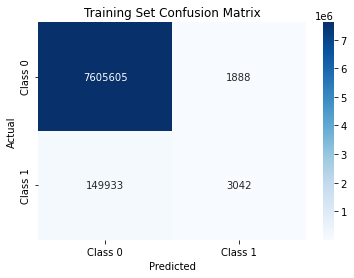

Training Set Confusion Matrix:
[[7605605    1888]
 [ 149933    3042]]


In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train, y_pred_train)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Set Confusion Matrix')
plt.show()

print("Training Set Confusion Matrix:")
print(cm)

In [67]:
# F1-score & ROC-AUC
y_prob_train = model.predict_proba(X_train)[:, 1]
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_prob_train)

print(f"F1-score of training: {f1_train}")
print(f"ROC-AUC of training: {roc_auc_train}")

F1-score of training: 0.038529495582787114
ROC-AUC of training: 0.8099365013891192


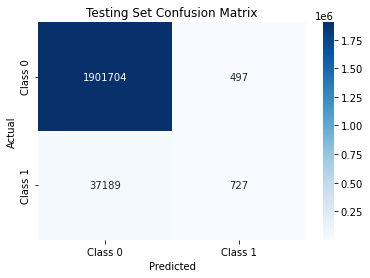

Testing Set Confusion Matrix:
[[1901704     497]
 [  37189     727]]


In [68]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Testing Set Confusion Matrix')
plt.show()

print("Testing Set Confusion Matrix:")
print(cm)

In [69]:
# F1-score & ROC-AUC
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"F1-score of testing: {f1}")
print(f"ROC-AUC of testing: {roc_auc}")

F1-score of testing: 0.037148696985181404
ROC-AUC of testing: 0.8084459636428502


In [125]:
coefficients = model.coef_.flatten()   # do not include beta_0

# Indexation explanation
odds_ratios = np.exp(coefficients)

In [101]:
# coef_df = pd.DataFrame({
#     'Feature': all_feature_names,
#     'Coefficient': coefficients
# })

# coef_df['Abs Coefficient'] = coef_df['Coefficient'].abs()
# coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False)

In [115]:
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

coef_df.to_csv("feature_coefficients.csv", index=False)

In [127]:
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'odds ratios': odds_ratios
})

coef_df_sorted = coef_df.sort_values(by='odds ratios', ascending=False)

In [128]:
pd.set_option('display.max_rows', None)

print(coef_df)

                                        Feature  odds ratios
0                                   DayOfWeek_1     0.798333
1                                   DayOfWeek_2     0.687674
2                                   DayOfWeek_3     0.715460
3                                   DayOfWeek_4     0.740894
4                                   DayOfWeek_5     0.715678
5                                   DayOfWeek_6     0.621198
6                                   DayOfWeek_7     0.650806
7                         Operating_Airline _9E     0.634648
8                         Operating_Airline _9K     0.703967
9                         Operating_Airline _AA     0.546306
10                        Operating_Airline _AS     1.848961
11                        Operating_Airline _AX     1.074697
12                        Operating_Airline _B6     0.636737
13                        Operating_Airline _C5     1.182094
14                        Operating_Airline _CP     0.165057
15                      

In [129]:
coef_df_sorted

,Feature,odds ratios
226,Origin_JHM,20.165477
611,Dest_JHM,11.763520
663,Dest_MMH,6.513672
301,Origin_OTH,5.245209
278,Origin_MMH,5.242906
160,Origin_EYW,4.363293
374,Origin_SJU,3.922050
194,Origin_HHH,3.843489
315,Origin_PIB,3.771128
248,Origin_LIH,3.690298


The closer it is to 1, the less significant it is

Visualization

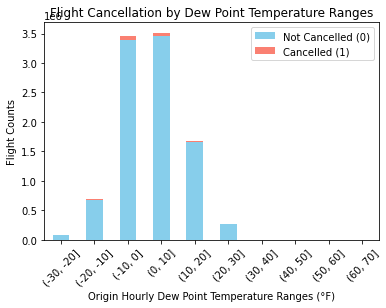

In [120]:
cancel_counts = (
    data.groupby([pd.cut(data['Origin_HourlyDewPointTemperature'], bins=np.arange(-30, 80, 10)), 'Cancelled'])
    .size()
    .unstack(fill_value=0)
)


cancel_counts.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.xlabel('Origin Hourly Dew Point Temperature Ranges (°F)')
plt.ylabel('Flight Counts')
plt.title('Flight Cancellation by Dew Point Temperature Ranges')
plt.legend(['Not Cancelled (0)', 'Cancelled (1)'])
plt.xticks(rotation=45)
plt.show()

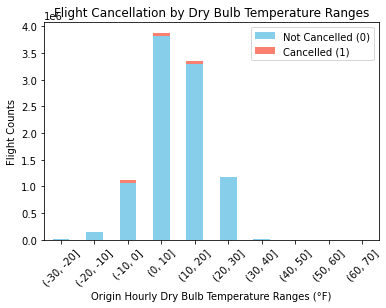

In [121]:
cancel_counts = (
    data.groupby([pd.cut(data['Origin_HourlyDryBulbTemperature'], bins=np.arange(-30, 80, 10)), 'Cancelled'])
    .size()
    .unstack(fill_value=0)
)


cancel_counts.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.xlabel('Origin Hourly Dry Bulb Temperature Ranges (°F)')
plt.ylabel('Flight Counts')
plt.title('Flight Cancellation by Dry Bulb Temperature Ranges')
plt.legend(['Not Cancelled (0)', 'Cancelled (1)'])
plt.xticks(rotation=45)
plt.show()